In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [3]:
training_df = pd.read_csv('../../data/training_df.csv')
valid_df = pd.read_csv('../../data/our_valid.csv')

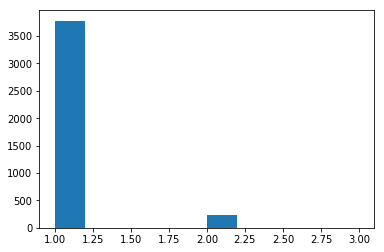

In [4]:
keypoints_per_arg = [x[1] for x in training_df[training_df.label == 1].arg_id.value_counts().to_dict().items()]
plt.hist(keypoints_per_arg)
plt.show()

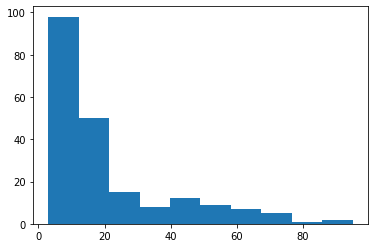

In [118]:
args_per_keypoints = [x[1] for x in training_df[training_df.label == 1].key_point_id.value_counts().to_dict().items()]
plt.hist(args_per_keypoints)
plt.show()

-------------

### Predicting:

In [5]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

sys.path.insert(0, "../../src-py")

In [6]:
from track_1_kp_matching import *

In [7]:
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler, losses, models, util
import torch

In [6]:
valid_df = pd.read_csv('../../data/our_valid.csv', index_col=0)
valid_keypoints_df = pd.read_csv('../../data/key_points_our_valid.csv')
valid_arguments_df = pd.read_csv('../../data/arguments_our_valid.csv')

In [8]:
def match_argument_with_keypoints(result, kp_dict, arg_dict):
    
    for arg, arg_embedding in arg_dict.items():
        result[arg] = {}
        for kp, kp_embedding in kp_dict.items():
            result[arg][kp] = util.pytorch_cos_sim(arg_embedding, kp_embedding).item()
        
        #Applying softmax
        kp_scores = list(result[arg].items())
        kp_ids, kp_scores = zip(*kp_scores)
        #print(kp_ids)
        #print(kp_scores)
        #kp_scores = torch.softmax(torch.Tensor(kp_scores), 0).tolist()
        #print(kp_scores)
        result[arg] = {kp_id:score for kp_id, score in zip(kp_ids, kp_scores)}
        

    return result

def predict(model, argument_df, keypoint_df, output_path, append_topic=False):
    argument_keypoints = {}
    for topic in argument_df.topic.unique():
        for stance in [-1, 1]:
            topic_keypoints_ids = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point_id'].tolist()
            topic_keypoints = keypoint_df[(keypoint_df.topic==topic) & (keypoint_df.stance==stance)]['key_point'].tolist()
            if append_topic:
                topic_keypoints = [topic + ' <SEP> ' + x for x in topic_keypoints]
                
            topic_keypoints_embeddings = model.encode(topic_keypoints)
            topic_kp_embed = dict(zip(topic_keypoints_ids, topic_keypoints_embeddings))

            topic_arguments_ids = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['arg_id'].tolist()
            topic_arguments = argument_df[(argument_df.topic==topic) & (argument_df.stance==stance)]['argument'].tolist()
            topic_arguments_embeddings = model.encode(topic_arguments)
            topic_arg_embed= dict(zip(topic_arguments_ids, topic_arguments_embeddings))

            argument_keypoints = match_argument_with_keypoints(argument_keypoints, topic_kp_embed, topic_arg_embed)
    
    json.dump(argument_keypoints, open(output_path, 'w'))
    
    return argument_keypoints

In [2]:
model = SentenceTransformer('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor_best_model')

In [9]:
models_list = [
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/albert-base-v2-contrastive-10-epochs-2021-06-08_14-28-59/',
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/distilroberta-base-contrastive-10-epochs-2021-06-08_14-00-18',
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-10-epochs-2021-06-08_13-05-35',
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-10-epochs-2021-05-28_16-41-01',
    '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-2021-05-28_16-28-54',
#     '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-kp_as_anchor_topic_added_all_neg_samples_6_epochs-2021-05-28_14-16-54',
#     '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-kp_as_anchor_topic_added_max_10_neg_samples_10_epochs-2021-05-28_14-16-14',
#     '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-kp_as_anchor_topic_added_max_20_neg_samples_10_epochs-2021-05-28_15-56-49',
#     '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-kp_as_anchor_topic_added_max_40_neg_samples_10_epochs-2021-05-28_14-15-45',
]

pred_output_path = '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/preds/'
subset_name= 'our_valid'

In [10]:
def predict_and_evaluate(argument_df, keypoint_df, gold_data_dir, subset_name):
    pred_df = {}
    for model_path in models_list:
        append_topic= 'topic_added' in model_path
        #Predict
        model = SentenceTransformer(model_path)
        model_name = model_path.split('/')[-1]
        predictions_file = pred_output_path+model_name+ '-' + subset_name + '-preds.json'
        json_preds = predict(model, argument_df, keypoint_df, predictions_file, append_topic)

        #Evaluate
        arg_df, kp_df, labels_df = load_kpm_data(gold_data_dir, subset=subset_name)
        merged_df = get_predictions(predictions_file, labels_df, arg_df)
        print('Evaluating {}:'.format(model_name))
        evaluate_predictions(merged_df)
        
        pred_df[model_name] = merged_df

    return pred_df

In [73]:
pred_dfs = predict_and_evaluate(valid_arguments_df, valid_keypoints_df,  '../../data', 'our_valid')

Evaluating bert-base-uncased-kp_as_anchor_topic_added_max_20_neg_samples-2021-05-27_11-20-47:
mAP strict= 0.8123734434931347 ; mAP relaxed = 0.9333860691751199


In [74]:
test_df = pd.read_csv('../../data/our_test.csv', index_col=0)
test_keypoints_df = pd.read_csv('../../data/key_points_our_test.csv')
test_arguments_df = pd.read_csv('../../data/arguments_our_test.csv')

In [75]:
_=predict_and_evaluate(test_arguments_df, test_keypoints_df,  '../../data', 'our_test')

Evaluating bert-base-uncased-kp_as_anchor_topic_added_max_20_neg_samples-2021-05-27_11-20-47:
mAP strict= 0.80416708344701 ; mAP relaxed = 0.939979400446195


In [62]:
_=predict_and_evaluate(test_arguments_df, test_keypoints_df,  '../../data', 'our_test')

Evaluating bert-base-uncased-kp_as_anchor-2021-05-24_15-58-35:
mAP strict= 0.8884606072596714 ; mAP relaxed = 0.963442996320446
Evaluating bert-base-uncased-kp_as_anchor_max_10_neg_samples-2021-05-26_11-20-51:
mAP strict= 0.7762677078765092 ; mAP relaxed = 0.8882839976095311


In [16]:
all_valid_arg_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/arguments_dev.csv')
all_valid_keypoints_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/key_points_dev.csv')

In [26]:
results_df = predict_and_evaluate(all_valid_arg_df, all_valid_keypoints_df, '../../KPA_2021_shared_task/kpm_data/', 'dev')

loaded predictions for 932 arguments
Evaluating :
mAP strict= 0.7186387417668926 ; mAP relaxed = 0.8925970253850469
loaded predictions for 932 arguments
Evaluating distilroberta-base-contrastive-10-epochs-2021-06-08_14-00-18:
mAP strict= 0.8390914685648296 ; mAP relaxed = 0.9711290620854796
loaded predictions for 932 arguments
Evaluating roberta-base-contrastive-10-epochs-2021-06-08_13-05-35:
mAP strict= 0.8368283555851979 ; mAP relaxed = 0.9639953870789683
loaded predictions for 932 arguments
Evaluating roberta-base-contrastive-10-epochs-2021-05-28_16-41-01:
mAP strict= 0.8407255406341027 ; mAP relaxed = 0.9605143550149072
loaded predictions for 932 arguments
Evaluating roberta-base-contrastive-2021-05-28_16-28-54:
mAP strict= 0.8149720295671921 ; mAP relaxed = 0.9679302049567932


---------

### Predicting on the final test set:

In [13]:
ls ../../KPA_2021_shared_task/test_data

arguments_test.csv  key_points_test.csv


In [25]:
test_arg_df = pd.read_csv('../../KPA_2021_shared_task/test_data/arguments_test.csv')
test_keypoints_df = pd.read_csv('../../KPA_2021_shared_task/test_data/key_points_test.csv')

In [29]:
test_pred_keypoints_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/pagerank-generated-test-keypoints.csv')

In [38]:
ls ../../

KPA_2021_shared_task/  notes.txt      src-ipynb/
README.md              paraphrasing/  src-py/
data/                  siamese-nn/    track-2-keypoint-extraction/


In [40]:
test_pred_keypoints_aspect_df = pd.read_csv('../../track-2-keypoint-extraction/test_split_with_aspects-key_points-x10.csv')

In [41]:
test_pred_keypoints_aspect_df.columns

Index(['key_point_id', 'key_point', 'topic', 'stance'], dtype='object')

In [30]:
test_pred_keypoints_df.columns

Index(['key_point_id', 'topic', 'stance', 'key_point'], dtype='object')

In [31]:
test_keypoints_df.columns

Index(['key_point_id', 'key_point', 'topic', 'stance'], dtype='object')

In [32]:
model = SentenceTransformer('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/distilroberta-base-contrastive-10-epochs-2021-06-08_14-00-18')
json_preds = predict(model, test_arg_df, test_keypoints_df, '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/distilroberta-based-final-test-preds.json', True)

In [33]:
model = SentenceTransformer('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-10-epochs-2021-06-08_13-05-35')
json_preds = predict(model, test_arg_df, test_keypoints_df, '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/roberta-based-final-test-preds.json', True)

In [34]:
model = SentenceTransformer('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-10-epochs-2021-06-08_13-05-35')
json_preds = predict(model, test_arg_df, test_pred_keypoints_df, '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/roberta-based-final-test-preds-track-2.json', True)

In [42]:
model = SentenceTransformer('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/roberta-base-contrastive-10-epochs-2021-06-08_13-05-35')
json_preds = predict(model, test_arg_df, test_pred_keypoints_aspect_df, '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/roberta-based-final-test-preds-aspcet-track-2.json', True)

-----------

### Analysis:

In [109]:
results_df = results_df['bert-base-uncased-kp_as_anchor_best_model']

In [93]:
results_df['bert-base-uncased-kp_as_anchor_best_model'].head()

,arg_id,topic,stance,key_point_id,score,label,label_strict,label_relaxed
0,arg_4_0,We should abandon the use of school uniform,-1,kp_4_1,0.833244,1.0,1.0,1.0
1,arg_4_1,We should abandon the use of school uniform,-1,kp_4_2,0.707487,1.0,1.0,1.0
2,arg_4_2,We should abandon the use of school uniform,-1,kp_4_3,0.822895,1.0,1.0,1.0
3,arg_4_3,We should abandon the use of school uniform,-1,kp_4_3,0.775373,1.0,1.0,1.0
4,arg_4_4,We should abandon the use of school uniform,-1,kp_4_2,0.708077,1.0,1.0,1.0


In [106]:
def get_ap(df, label_column, top_percentile=0.5):
    top = int(len(df)*top_percentile)
    df = df.sort_values('score', ascending=False).head(top)
    return average_precision_score(y_true=df[label_column], y_score=df["score"])

def calc_mean_average_precision(df, label_column):
    precisions = [get_ap(group, label_column, top_percentile=0.5) for _, group in df.groupby(["topic", "stance"])]
    return np.mean(precisions)

In [107]:
calc_mean_average_precision(results_df['bert-base-uncased-kp_as_anchor_best_model'], 'label_relaxed')

0.9531621481387572

In [113]:
results_df[results_df.topic == 'We should abandon the use of school uniform'].sort_values('score')

,arg_id,topic,stance,key_point_id,score,label,label_strict,label_relaxed
214,arg_4_214,We should abandon the use of school uniform,1,kp_4_9,-0.038800,NaN,0.0,1.0
136,arg_4_136,We should abandon the use of school uniform,1,kp_4_9,0.015576,0.0,0.0,0.0
223,arg_4_223,We should abandon the use of school uniform,1,kp_4_9,0.041475,0.0,0.0,0.0
178,arg_4_178,We should abandon the use of school uniform,1,kp_4_5,0.052808,1.0,1.0,1.0
194,arg_4_194,We should abandon the use of school uniform,1,kp_4_9,0.077202,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...
45,arg_4_45,We should abandon the use of school uniform,-1,kp_4_1,0.976696,1.0,1.0,1.0
82,arg_4_82,We should abandon the use of school uniform,-1,kp_4_1,0.981591,1.0,1.0,1.0
149,arg_4_149,We should abandon the use of school uniform,1,kp_4_6,0.982449,1.0,1.0,1.0
156,arg_4_156,We should abandon the use of school uniform,1,kp_4_6,0.984104,1.0,1.0,1.0


In [114]:
results_df[results_df.arg_id == 'arg_4_178'].sort_values('score')

,arg_id,topic,stance,key_point_id,score,label,label_strict,label_relaxed
178,arg_4_178,We should abandon the use of school uniform,1,kp_4_5,0.052808,1.0,1.0,1.0


In [118]:
pred = json.load(open('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/preds/bert-base-uncased-kp_as_anchor_best_model-dev-preds.json'))

In [122]:
import torch

In [ ]:
[x]

In [131]:
list(pred['arg_4_178'].values())

[0.05280778557062149,
 -0.18674007058143616,
 -0.1372978389263153,
 -0.2439197152853012,
 0.04507965222001076]

In [145]:
t = torch.tensor(list(pred['arg_4_178'].values()), dtype=torch.float)

In [148]:
torch.softmax(t, 0)

tensor([0.2299, 0.1809, 0.1901, 0.1709, 0.2281])

In [119]:
pred['arg_4_178']

{'kp_4_5': 0.05280778557062149,
 'kp_4_6': -0.18674007058143616,
 'kp_4_7': -0.1372978389263153,
 'kp_4_8': -0.2439197152853012,
 'kp_4_9': 0.04507965222001076}

In [120]:
pred['arg_4_149']

{'kp_4_5': -0.16205520927906036,
 'kp_4_6': 0.9824493527412415,
 'kp_4_7': -0.15135669708251953,
 'kp_4_8': -0.015851741656661034,
 'kp_4_9': -0.21924754977226257}